In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('water_dataX.csv', encoding='ISO-8859-1')
    
# Quick inspection
print(df.shape)
print(df.info())
df.head()


(1991, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   STATION CODE                      1991 non-null   object
 1   LOCATIONS                         1991 non-null   object
 2   STATE                             1991 non-null   object
 3   Temp                              1991 non-null   object
 4   D.O. (mg/l)                       1991 non-null   object
 5   PH                                1991 non-null   object
 6   CONDUCTIVITY (ï¿½mhos/cm)         1991 non-null   object
 7   B.O.D. (mg/l)                     1991 non-null   object
 8   NITRATENAN N+ NITRITENANN (mg/l)  1991 non-null   object
 9   FECAL COLIFORM (MPN/100ml)        1991 non-null   object
 10  TOTAL COLIFORM (MPN/100ml)Mean    1991 non-null   object
 11  year                              1991 non-null   int64 
dtypes: int64(

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (ï¿½mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [2]:

# Rename mislabelled columns
df = df.rename(columns={'CONDUCTIVITY (ï¿½mhos/cm)': 'CONDUCTIVITY (µmhos/cm)'})


In [3]:

df = df.drop_duplicates()
print("Remaining rows after removing duplicates:", len(df))

Remaining rows after removing duplicates: 1990


In [4]:

# Define numeric columns
numeric_cols = ['Temp', 'D.O. (mg/l)', 'PH', 'CONDUCTIVITY (µmhos/cm)', 
                'B.O.D. (mg/l)', 'NITRATENAN N+ NITRITENANN (mg/l)', 
                'FECAL COLIFORM (MPN/100ml)', 'TOTAL COLIFORM (MPN/100ml)Mean', 'year']

# Convert to numeric
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[numeric_cols].dtypes


Temp                                float64
D.O. (mg/l)                         float64
PH                                  float64
CONDUCTIVITY (µmhos/cm)             float64
B.O.D. (mg/l)                       float64
NITRATENAN N+ NITRITENANN (mg/l)    float64
FECAL COLIFORM (MPN/100ml)          float64
TOTAL COLIFORM (MPN/100ml)Mean      float64
year                                  int64
dtype: object

In [5]:
# Example: Negative values for concentrations are invalid
invalid = df[numeric_cols].lt(0).any()
print("Columns with negative values:", invalid[invalid].index.tolist())

# We've already handled this in contamination check, but double-check
assert not df[numeric_cols].lt(0).any().any(), "Negative values found"



Columns with negative values: []


In [6]:
# Convert year to string and check length
invalid_year_format = df['year'].astype(str).str.match(r'^\d{4}$') == False

print(f"Found {invalid_year_format.sum()} rows with non-4-digit years")
print(df.loc[invalid_year_format, ['STATION CODE', 'year']].head())

Found 0 rows with non-4-digit years
Empty DataFrame
Columns: [STATION CODE, year]
Index: []


In [7]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [8]:
# Make a copy of the original numeric data before outlier treatment
df_before_outliers = df[numeric_cols].copy()
# Treat outliers using IQR
def treat_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)
    return df

for col in numeric_cols:
    df = treat_outliers(df, col)


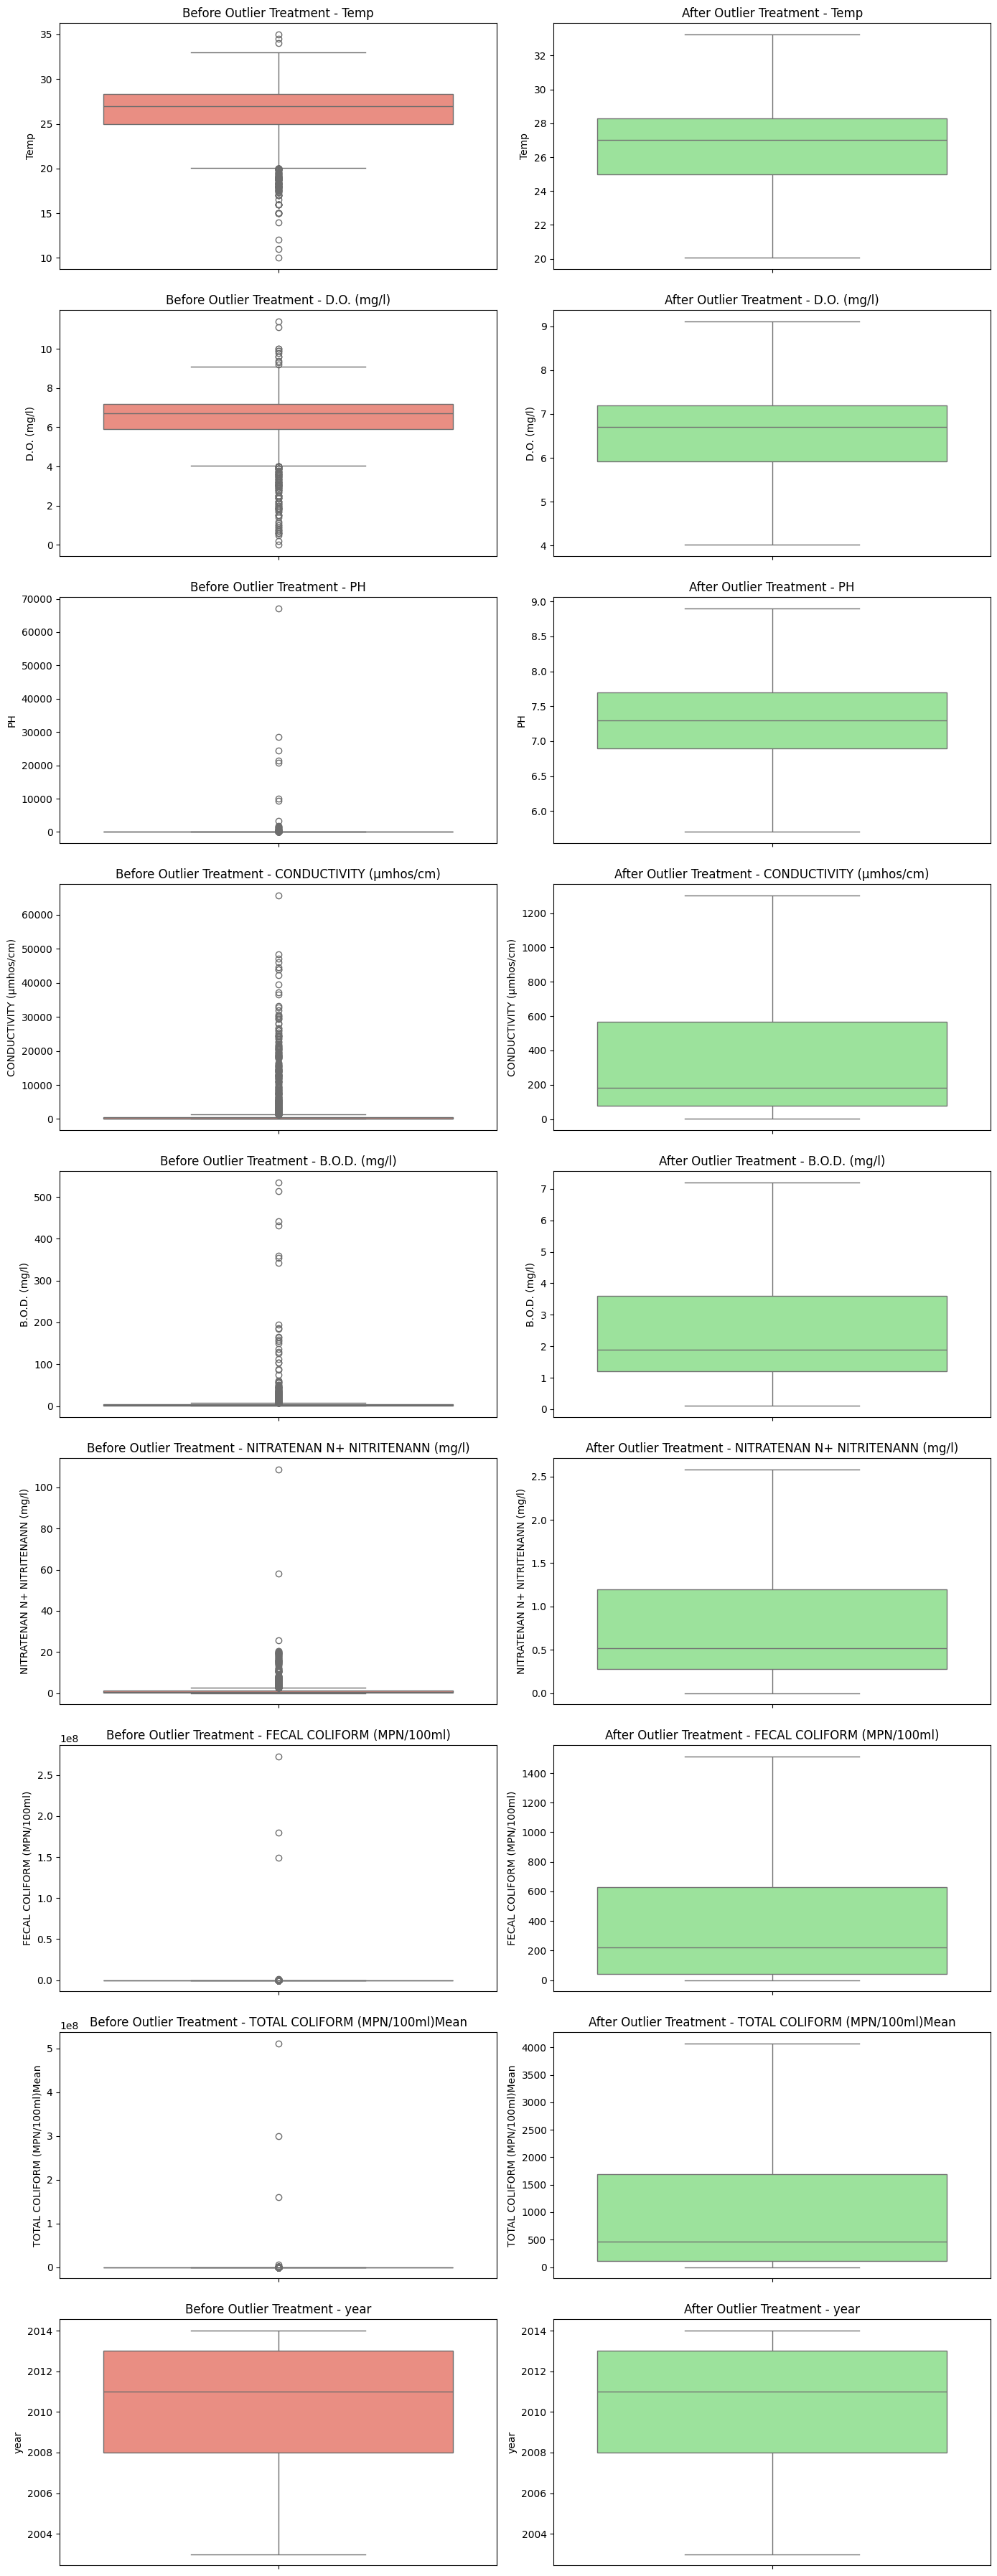

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=2, figsize=(14, 4 * len(numeric_cols)))

# Loop through each numeric column to show before and after
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df_before_outliers[col], ax=axes[i, 0], color='salmon')
    axes[i, 0].set_title(f"Before Outlier Treatment - {col}")
    
    sns.boxplot(y=df[col], ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f"After Outlier Treatment - {col}")

plt.tight_layout()
plt.show()

In [10]:
# Step 8: Clean and Encode `STATE` Column

import numpy as np

# --- Normalize State Strings ---
def normalize_state_string(s):
    if pd.isna(s):
        return np.nan
    s = str(s).upper().strip()
    s = s.replace('&', ' AND ').replace(',', ' AND ')
    s = s.replace('DADRA AND NAGAR AND HAVELI', 'DAMAN AND DIU')
    s = ' '.join(s.split())  # Remove double spaces
    return s

df['STATE'] = df['STATE'].replace(['NAN', 'NA', ''], np.nan)
df['STATE'] = df['STATE'].apply(normalize_state_string)

# --- Extract from LOCATIONS ---
def extract_state_from_location(loc):
    if pd.isna(loc):
        return np.nan
    loc = str(loc).upper()
    
    # Special cases
    if 'KABBANI' in loc or 'BHAVANI' in loc:
        return 'KERALA'
    if 'CHANDIGARH' in loc:
        return 'PUNJAB'
    
    state_patterns = {
        'ANDHRA PRADESH': ['ANDHRA', 'A.P.'],
        'DAMAN AND DIU': ['DAMAN', 'DIU', 'DADRA', 'HAVELI'],
        'GOA': ['GOA', 'ZUARI', 'MANDOVI'],
        'GUJARAT': ['GUJARAT'],
        'HARYANA': ['HARYANA'],
        'HIMACHAL PRADESH': ['HIMACHAL'],
        'KARNATAKA': ['KARNATAKA'],
        'KERALA': ['KERALA'],
        'MADHYA PRADESH': ['MADHYA'],
        'MAHARASHTRA': ['MAHARASHTRA'],
        'MANIPUR': ['MANIPUR'],
        'MEGHALAYA': ['MEGHALAYA'],
        'MIZORAM': ['MIZORAM'],
        'ODISHA': ['ODISHA', 'ORISSA'],
        'PONDICHERRY': ['PONDICHERRY'],
        'PUNJAB': ['PUNJAB'],
        'RAJASTHAN': ['RAJASTHAN'],
        'TAMIL NADU': ['TAMILNADU', 'TAMIL NADU'],
        'TRIPURA': ['TRIPURA'],
        'UTTAR PRADESH': ['UTTAR', 'PRADESH']
    }
    
    for state, patterns in state_patterns.items():
        if any(pattern in loc for pattern in patterns):
            return state
    return np.nan

location_based_states = df['LOCATIONS'].apply(extract_state_from_location)
df['STATE'] = df['STATE'].fillna(location_based_states)

# --- Fill using STATION CODE mapping ---
station_state_map = df.dropna(subset=['STATE']).drop_duplicates('STATION CODE')\
                      .set_index('STATION CODE')['STATE'].to_dict()

df['STATE'] = df.apply(
    lambda row: station_state_map.get(row['STATION CODE'], row['STATE']),
    axis=1
)

# --- Final standardization ---
state_mapping = {
    'ANDHRA PRADESH': ['ANDHRA', 'A.P.'],
    'DAMAN AND DIU': ['DAMAN', 'DIU', 'DADRA', 'HAVELI'],
    'GOA': ['GOA', 'ZUARI', 'MANDOVI'],
    'GUJARAT': ['GUJARAT'],
    'HARYANA': ['HARYANA'],
    'HIMACHAL PRADESH': ['HIMACHAL'],
    'KARNATAKA': ['KARNATAKA'],
    'KERALA': ['KERALA'],
    'MADHYA PRADESH': ['MADHYA'],
    'MAHARASHTRA': ['MAHARASHTRA'],
    'MANIPUR': ['MANIPUR'],
    'MEGHALAYA': ['MEGHALAYA'],
    'MIZORAM': ['MIZORAM'],
    'ODISHA': ['ODISHA', 'ORISSA'],
    'PONDICHERRY': ['PONDICHERRY'],
    'PUNJAB': ['PUNJAB'],
    'RAJASTHAN': ['RAJASTHAN'],
    'TAMIL NADU': ['TAMILNADU', 'TAMIL NADU'],
    'TRIPURA': ['TRIPURA'],
    'UTTAR PRADESH': ['UTTAR', 'PRADESH']
}

def standardize_state(state):
    if pd.isna(state):
        return np.nan
    state = normalize_state_string(state)
    for std, variants in state_mapping.items():
        if any(v in state for v in variants):
            return std
    return state

df['STATE'] = df['STATE'].apply(standardize_state)

# --- Option A: Drop if still missing ---
df = df.dropna(subset=['STATE'])  # Only truly unrecoverable ones


# Verification
print("✅ Cleaned and standardized STATE column")
print(df['STATE'].value_counts())

✅ Cleaned and standardized STATE column
STATE
KERALA              530
MAHARASHTRA         223
GOA                 181
MEGHALAYA           151
ANDHRA PRADESH      144
MANIPUR             123
PUNJAB              114
GUJARAT              98
TAMIL NADU           96
ODISHA               73
HARYANA              43
MIZORAM              36
PONDICHERRY          33
DAMAN AND DIU        32
KARNATAKA            30
RAJASTHAN            28
TRIPURA              27
HIMACHAL PRADESH     26
MADHYA PRADESH        2
Name: count, dtype: int64


In [11]:

df = pd.concat([df, pd.get_dummies(df['STATE'], prefix='STATE', dtype=int)], axis=1)


In [12]:

# Drop non-numeric and redundant columns
df_clean = df.drop(columns=['LOCATIONS', 'STATION CODE', 'STATE'])

# Show final dataframe
df_clean


,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year,STATE_ANDHRA PRADESH,...,STATE_MAHARASHTRA,STATE_MANIPUR,STATE_MEGHALAYA,STATE_MIZORAM,STATE_ODISHA,STATE_PONDICHERRY,STATE_PUNJAB,STATE_RAJASTHAN,STATE_TAMIL NADU,STATE_TRIPURA
0,30.6,6.7,7.5,203.0,1.8965,0.100,11.000,27.000,2014.0,0,...,0,0,0,0,0,0,0,0,0,0
1,29.8,5.7,7.2,189.0,2.0000,0.200,1511.625,4068.625,2014.0,0,...,0,0,0,0,0,0,0,0,0,0
2,29.5,6.3,6.9,179.0,1.7000,0.100,1511.625,4068.625,2014.0,0,...,0,0,0,0,0,0,0,0,0,0
3,29.7,5.8,6.9,64.0,3.8000,0.500,1511.625,4068.625,2014.0,0,...,0,0,0,0,0,0,0,0,0,0
4,29.5,5.8,7.3,83.0,1.9000,0.400,1511.625,4068.625,2014.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,27.0,7.9,8.9,7.2,2.7000,0.518,0.518,202.000,2003.0,0,...,0,0,0,0,0,0,0,0,1,0
1987,29.0,7.5,8.9,6.3,2.6000,0.155,0.155,315.000,2003.0,0,...,0,0,0,0,0,0,0,0,1,0
1988,28.0,7.6,8.9,6.2,1.2000,0.516,221.000,570.000,2003.0,0,...,0,0,0,0,0,0,0,0,0,1
1989,28.0,7.7,8.9,6.5,1.3000,0.516,221.000,562.000,2003.0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
# Numeric water parameters (need scaling)
numeric_cols = ['Temp', 'D.O. (mg/l)', 'PH', 'CONDUCTIVITY (µmhos/cm)', 
               'B.O.D. (mg/l)', 'NITRATENAN N+ NITRITENANN (mg/l)',
               'FECAL COLIFORM (MPN/100ml)', 'TOTAL COLIFORM (MPN/100ml)Mean', 'year']

# One-hot encoded states (should NOT be scaled)
state_cols = [col for col in df.columns if col.startswith('STATE_')]

# Other columns (like 'Cluster' if exists)
other_cols = list(set(df.columns) - set(numeric_cols) - set(state_cols))

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df_clean.copy()  # Preserve original data

# Scale only numeric columns
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [15]:
print("Scaled numeric features summary:")
print(df_scaled[numeric_cols].describe().loc[['mean', 'std']])

Scaled numeric features summary:
              Temp   D.O. (mg/l)            PH  CONDUCTIVITY (µmhos/cm)  \
mean -4.106151e-16  2.570808e-16  4.927382e-16             2.677925e-17   
std   1.000251e+00  1.000251e+00  1.000251e+00             1.000251e+00   

      B.O.D. (mg/l)  NITRATENAN N+ NITRITENANN (mg/l)  \
mean  -2.856453e-17                      1.142581e-16   
std    1.000251e+00                      1.000251e+00   

      FECAL COLIFORM (MPN/100ml)  TOTAL COLIFORM (MPN/100ml)Mean          year  
mean               -3.570567e-18                   -6.427020e-17 -4.570325e-15  
std                 1.000251e+00                    1.000251e+00  1.000251e+00  


In [16]:
df_scaled

,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year,STATE_ANDHRA PRADESH,...,STATE_MAHARASHTRA,STATE_MANIPUR,STATE_MEGHALAYA,STATE_MIZORAM,STATE_ODISHA,STATE_PONDICHERRY,STATE_PUNJAB,STATE_RAJASTHAN,STATE_TAMIL NADU,STATE_TRIPURA
0,1.426943,0.212185,0.285922,-0.439784,-0.385844,-0.914394,-0.815974,-0.789033,1.296637,0,...,0,0,0,0,0,0,0,0,0,0
1,1.157093,-0.716602,-0.201747,-0.471501,-0.338132,-0.798248,1.923634,2.005554,1.296637,0,...,0,0,0,0,0,0,0,0,0,0
2,1.055899,-0.159329,-0.689417,-0.494156,-0.476427,-0.914394,1.923634,2.005554,1.296637,0,...,0,0,0,0,0,0,0,0,0,0
3,1.123361,-0.623723,-0.689417,-0.754685,0.491641,-0.449809,1.923634,2.005554,1.296637,0,...,0,0,0,0,0,0,0,0,0,0
4,1.055899,-0.623723,-0.039191,-0.711641,-0.384230,-0.565956,1.923634,2.005554,1.296637,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,0.212617,1.326730,2.561713,-0.883364,-0.015442,-0.428903,-0.835111,-0.668029,-2.302119,0,...,0,0,0,0,0,0,0,0,1,0
1987,0.887242,0.955215,2.561713,-0.885403,-0.061541,-0.850513,-0.835774,-0.589895,-2.302119,0,...,0,0,0,0,0,0,0,0,1,0
1988,0.549929,1.048094,2.561713,-0.885629,-0.706920,-0.431226,-0.432589,-0.413575,-2.302119,0,...,0,0,0,0,0,0,0,0,0,1
1989,0.549929,1.140972,2.561713,-0.884950,-0.660821,-0.431226,-0.432589,-0.419106,-2.302119,0,...,0,0,0,0,0,0,0,0,0,1


## Step 1: Hyper-parameter Tuning (Spectral Clusetering)
Author: Ng Zher Xian

### For hyper parameter tunning, 4 different dataset have been tested:

X : contain numerical cols and state cols

X_PCA : PCA (numerical cols and state cols)

Y : contain numericals cols only

Y_PCA : PCA (Numerical cols only)

### the highest silhoutte score will be use for fine-tuning

## Sprectral clustering

# X

In [17]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

# Define the features (scaled numeric and one-hot encoded states)
X = df_scaled[numeric_cols + state_cols]

# Set up the parameter grid with n_neighbors added
param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'affinity': ['nearest_neighbors', 'rbf'],
    'assign_labels': ['kmeans', 'discretize', 'cluster_qr'],
    'n_neighbors': [5, 10, 15]  # Only relevant if affinity is 'nearest_neighbors'
}

# Initialize variables to store the best scores and parameters
best_score = -1
best_params = None
best_metrics = {}

# Iterate over all parameter combinations
for params in ParameterGrid(param_grid):
    try:
        spectral = SpectralClustering(
            n_clusters=params['n_clusters'],
            affinity=params['affinity'],
            assign_labels=params['assign_labels'],
            random_state=42,
            n_neighbors=params.get('n_neighbors', 10)  # Required only if affinity = 'nearest_neighbors'
        )
        
        labels = spectral.fit_predict(X)
        
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        
        if sil_score > best_score:
            best_score = sil_score
            best_params = params
            best_metrics = {
                'Silhouette Score': sil_score,
                'Davies-Bouldin Index': db_score,
                'Calinski-Harabasz Index': ch_score
            }

    except Exception as e:
        print(f"Skipping params {params} due to error: {e}")

# Output the best parameters and all metrics
print("Best Hyperparameters:", best_params)
print("Evaluation Metrics:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Fit final model
final_model = SpectralClustering(
    n_clusters=best_params['n_clusters'],
    affinity=best_params['affinity'],
    assign_labels=best_params['assign_labels'],
    random_state=42,
    n_neighbors=best_params.get('n_neighbors', 10)
)
final_labels = final_model.fit_predict(X)

# Add cluster labels to the dataframe
df['Cluster'] = final_labels


c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work 

Best Hyperparameters: {'affinity': 'rbf', 'assign_labels': 'kmeans', 'n_clusters': 2, 'n_neighbors': 5}
Evaluation Metrics:
Silhouette Score: 0.3289
Davies-Bouldin Index: 0.9550
Calinski-Harabasz Index: 373.6252


# Y

In [18]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

# Define the features (scaled numeric and one-hot encoded states)
Y = df_scaled[numeric_cols]

# Set up the parameter grid with n_neighbors added
param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'affinity': ['nearest_neighbors', 'rbf'],
    'assign_labels': ['kmeans', 'discretize', 'cluster_qr'],
    'n_neighbors': [5, 10, 15]  # Only relevant if affinity is 'nearest_neighbors'
}

# Initialize variables to store the best scores and parameters
best_score = -1
best_params = None
best_metrics = {}

# Iterate over all parameter combinations
for params in ParameterGrid(param_grid):
    try:
        spectral = SpectralClustering(
            n_clusters=params['n_clusters'],
            affinity=params['affinity'],
            assign_labels=params['assign_labels'],
            random_state=42,
            n_neighbors=params.get('n_neighbors', 10)  # Required only if affinity = 'nearest_neighbors'
        )
        
        labels = spectral.fit_predict(Y)
        
        sil_score = silhouette_score(Y, labels)
        db_score = davies_bouldin_score(Y, labels)
        ch_score = calinski_harabasz_score(Y, labels)
        
        if sil_score > best_score:
            best_score = sil_score
            best_params = params
            best_metrics = {
                'Silhouette Score': sil_score,
                'Davies-Bouldin Index': db_score,
                'Calinski-Harabasz Index': ch_score
            }

    except Exception as e:
        print(f"Skipping params {params} due to error: {e}")

# Output the best parameters and all metrics
print("Best Hyperparameters:", best_params)
print("Evaluation Metrics:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Fit final model
final_model = SpectralClustering(
    n_clusters=best_params['n_clusters'],
    affinity=best_params['affinity'],
    assign_labels=best_params['assign_labels'],
    random_state=42,
    n_neighbors=best_params.get('n_neighbors', 10)
)
final_labels = final_model.fit_predict(Y)

# Add cluster labels to the dataframe
df['Cluster'] = final_labels


c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work 

Best Hyperparameters: {'affinity': 'rbf', 'assign_labels': 'kmeans', 'n_clusters': 2, 'n_neighbors': 5}
Evaluation Metrics:
Silhouette Score: 0.3502
Davies-Bouldin Index: 0.9420
Calinski-Harabasz Index: 429.1700


# X_PCA

In [19]:
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

# Assuming df_scaled is already scaled
X = df_scaled[numeric_cols + state_cols]  # Pre-scaled data

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

# Parameter grid with both 'affinity' types and 'n_neighbors'
param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'affinity': ['nearest_neighbors', 'rbf'],
    'assign_labels': ['kmeans', 'discretize'],
    'n_neighbors': [5, 10, 15]  # Only used when affinity == 'nearest_neighbors'
}

# Initialize variables to track best result
best_score = -1
best_params = None
best_metrics = {}

# Grid search
for params in ParameterGrid(param_grid):
    try:
        # Only use 'n_neighbors' when affinity is 'nearest_neighbors'
        if params['affinity'] == 'nearest_neighbors':
            model = SpectralClustering(
                n_clusters=params['n_clusters'],
                affinity=params['affinity'],
                assign_labels=params['assign_labels'],
                n_neighbors=params['n_neighbors'],
                random_state=42
            )
        else:
            model = SpectralClustering(
                n_clusters=params['n_clusters'],
                affinity=params['affinity'],
                assign_labels=params['assign_labels'],
                random_state=42
            )

        # Fit and predict
        labels = model.fit_predict(X_pca)

        # Calculate metrics
        sil_score = silhouette_score(X_pca, labels)
        db_score = davies_bouldin_score(X_pca, labels)
        ch_score = calinski_harabasz_score(X_pca, labels)

        # Track best model based on silhouette score
        if sil_score > best_score:
            best_score = sil_score
            best_params = params
            best_metrics = {
                'Silhouette Score': sil_score,
                'Davies-Bouldin Index': db_score,
                'Calinski-Harabasz Index': ch_score
            }

    except Exception as e:
        print(f"⚠️ Skipping params {params} due to error: {e}")

# Print best configuration and scores
print("\n✅ Best Hyperparameters:", best_params)
print("📊 Evaluation Metrics:")
for k, v in best_metrics.items():
    print(f"  {k}: {v:.4f}")

# Fit final model with best params
if best_params['affinity'] == 'nearest_neighbors':
    final_model = SpectralClustering(
        n_clusters=best_params['n_clusters'],
        affinity=best_params['affinity'],
        assign_labels=best_params['assign_labels'],
        n_neighbors=best_params['n_neighbors'],
        random_state=42
    )
else:
    final_model = SpectralClustering(
        n_clusters=best_params['n_clusters'],
        affinity=best_params['affinity'],
        assign_labels=best_params['assign_labels'],
        random_state=42
    )

final_labels = final_model.fit_predict(X_pca)
df['Cluster'] = final_labels


c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work 


✅ Best Hyperparameters: {'affinity': 'rbf', 'assign_labels': 'kmeans', 'n_clusters': 2, 'n_neighbors': 5}
📊 Evaluation Metrics:
  Silhouette Score: 0.3402
  Davies-Bouldin Index: 0.9529
  Calinski-Harabasz Index: 413.4342


# Y_PCA

In [20]:
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

# Assuming df_scaled is already scaled
Y = df_scaled[numeric_cols]  # Pre-scaled data

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
Y_pca = pca.fit_transform(Y)

# Parameter grid with both 'affinity' types and 'n_neighbors'
param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'affinity': ['nearest_neighbors', 'rbf'],
    'assign_labels': ['kmeans', 'discretize'],
    'n_neighbors': [5, 10, 15]  # Only used when affinity == 'nearest_neighbors'
}

# Initialize variables to track best result
best_score = -1
best_params = None
best_metrics = {}

# Grid search
for params in ParameterGrid(param_grid):
    try:
        # Only use 'n_neighbors' when affinity is 'nearest_neighbors'
        if params['affinity'] == 'nearest_neighbors':
            model = SpectralClustering(
                n_clusters=params['n_clusters'],
                affinity=params['affinity'],
                assign_labels=params['assign_labels'],
                n_neighbors=params['n_neighbors'],
                random_state=42
            )
        else:
            model = SpectralClustering(
                n_clusters=params['n_clusters'],
                affinity=params['affinity'],
                assign_labels=params['assign_labels'],
                random_state=42
            )

        # Fit and predict
        labels = model.fit_predict(Y_pca)

        # Calculate metrics
        sil_score = silhouette_score(Y_pca, labels)
        db_score = davies_bouldin_score(Y_pca, labels)
        ch_score = calinski_harabasz_score(Y_pca, labels)

        # Track best model based on silhouette score
        if sil_score > best_score:
            best_score = sil_score
            best_params = params
            best_metrics = {
                'Silhouette Score': sil_score,
                'Davies-Bouldin Index': db_score,
                'Calinski-Harabasz Index': ch_score
            }

    except Exception as e:
        print(f"⚠️ Skipping params {params} due to error: {e}")

# Print best configuration and scores
print("\n✅ Best Hyperparameters:", best_params)
print("📊 Evaluation Metrics:")
for k, v in best_metrics.items():
    print(f"  {k}: {v:.4f}")

# Fit final model with best params
if best_params['affinity'] == 'nearest_neighbors':
    final_model = SpectralClustering(
        n_clusters=best_params['n_clusters'],
        affinity=best_params['affinity'],
        assign_labels=best_params['assign_labels'],
        n_neighbors=best_params['n_neighbors'],
        random_state=42
    )
else:
    final_model = SpectralClustering(
        n_clusters=best_params['n_clusters'],
        affinity=best_params['affinity'],
        assign_labels=best_params['assign_labels'],
        random_state=42
    )

final_labels = final_model.fit_predict(Y_pca)
df['Cluster'] = final_labels


c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work 


✅ Best Hyperparameters: {'affinity': 'rbf', 'assign_labels': 'kmeans', 'n_clusters': 2, 'n_neighbors': 5}
📊 Evaluation Metrics:
  Silhouette Score: 0.3524
  Davies-Bouldin Index: 0.9374
  Calinski-Harabasz Index: 433.6725


### After perform 4 test, Y_PCA [PCA(Numerical cols only)] have the highest silhoutte score, lowest DBI, and highest CHI. Therefore, Y_PCA will be use for fine-tunning

below are the follwing hyperparameter

 Best Hyperparameters: 

  'affinity': 'rbf'

  'assign_labels': 'kmeans'

  'n_clusters': 2

  'n_neighbors': 5 ##not be using since assign_lables is kmeans




## Y_PCA Visualisation

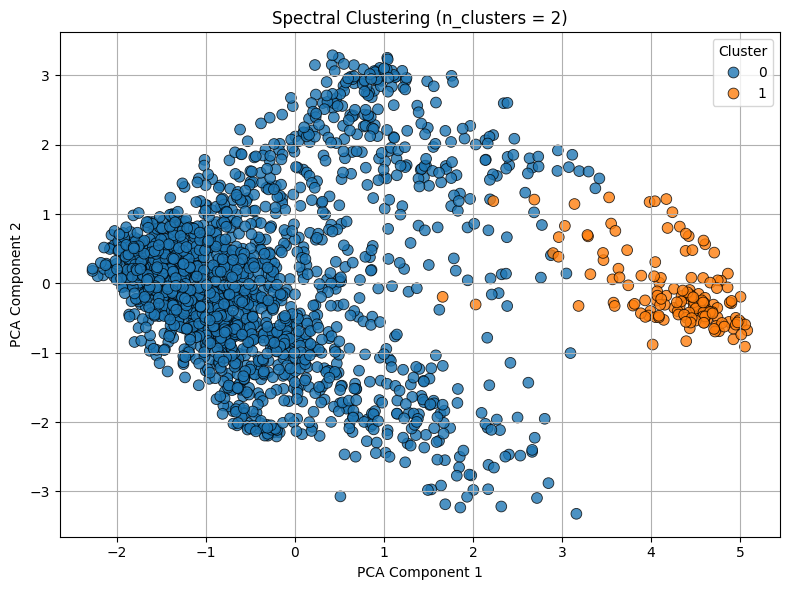

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the first 2 principal components for visualization
X_vis = Y_pca[:, :2]  # Only 2 columns for 2D plot
cluster_labels = df['Cluster']

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_vis[:, 0], y=X_vis[:, 1],
    hue=cluster_labels,
    palette='tab10',
    s=60,
    alpha=0.8,
    edgecolor='k'
)
plt.title(f"Spectral Clustering (n_clusters = {best_params['n_clusters']})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()



# FINE-TUNING

## CHANGING N_CLUSTER

n_clusters = 3 ➤ Silhouette Score = 0.2557


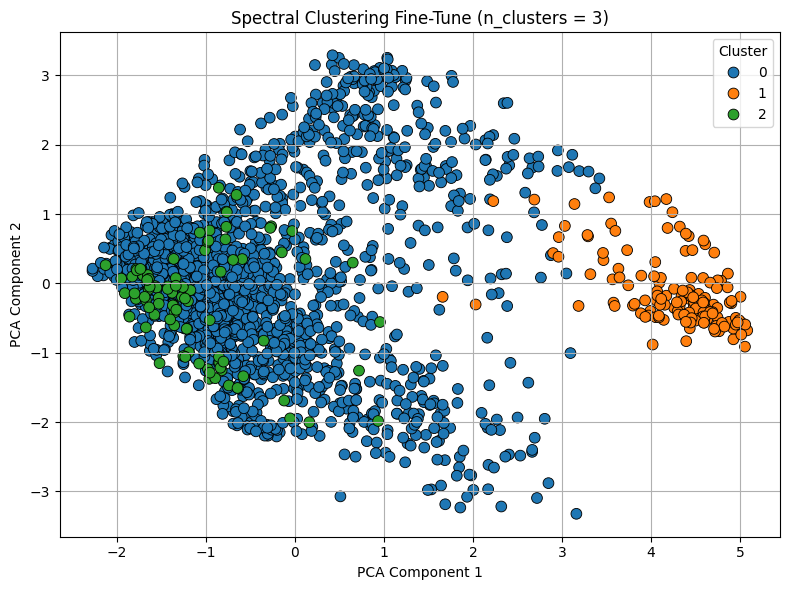

n_clusters = 4 ➤ Silhouette Score = 0.1969


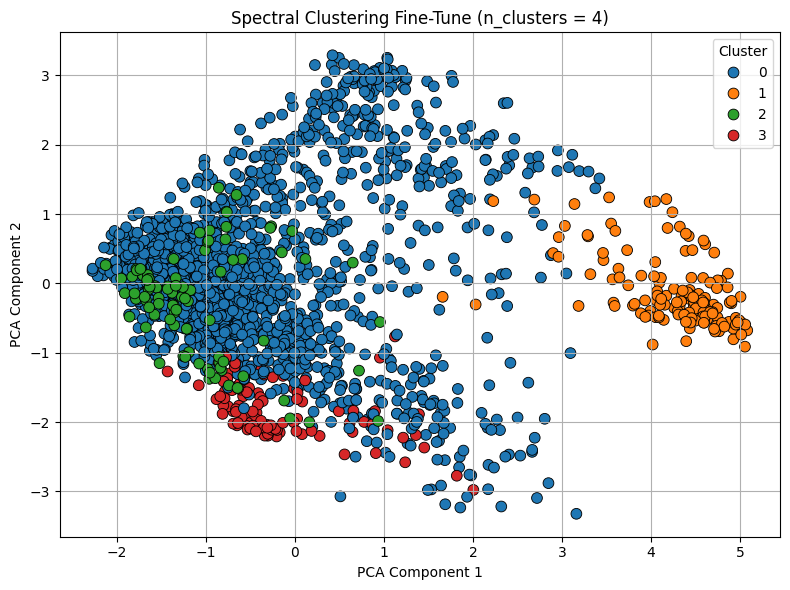

In [22]:
from sklearn.metrics import silhouette_score

for k in [3, 4]:
    model = SpectralClustering(
        n_clusters=k,
        affinity='rbf',
        assign_labels='kmeans',
        random_state=42
    )
    labels = model.fit_predict(Y_pca)
    
    sil = silhouette_score(Y_pca, labels)
    print(f"n_clusters = {k} ➤ Silhouette Score = {sil:.4f}")
    
    # Visualize
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=Y_pca[:, 0], y=Y_pca[:, 1], hue=labels, palette='tab10', s=60, edgecolor='k')
    plt.title(f"Spectral Clustering Fine-Tune (n_clusters = {k})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


After increasing number of cluster the shiloute score become lower, and cluster become more overlap. Therefore remain n_cluster = 2

## CHANGING PCA

In [23]:
for var in [0.90, 0.95, 0.99]:
    pca = PCA(n_components=var)
    Y_pca_var = pca.fit_transform(Y)

    model = SpectralClustering(
        n_clusters=2,
        affinity='rbf',
        assign_labels='kmeans',
        random_state=42
    )
    labels = model.fit_predict(Y_pca_var)
    sil = silhouette_score(Y_pca_var, labels)
    print(f"PCA {var:.2f} ➤ Silhouette Score = {sil:.4f}")


PCA 0.90 ➤ Silhouette Score = 0.3650
PCA 0.95 ➤ Silhouette Score = 0.3524
PCA 0.99 ➤ Silhouette Score = 0.3524


By changing PCA to 0.90, we obtain a higher value of silhoutte score, therefore PCA will be adjusted to 0.90

In [24]:
for var in [2]:
    pca = PCA(n_components=var)
    Y_pca_var = pca.fit_transform(Y)

    model = SpectralClustering(
        n_clusters=2,
        affinity='rbf',
        assign_labels='kmeans',
        random_state=42
    )
    labels = model.fit_predict(Y_pca_var)
    sil = silhouette_score(Y_pca_var, labels)
    print(f"PCA {var:.2f} ➤ Silhouette Score = {sil:.4f}")



PCA 2.00 ➤ Silhouette Score = 0.5749


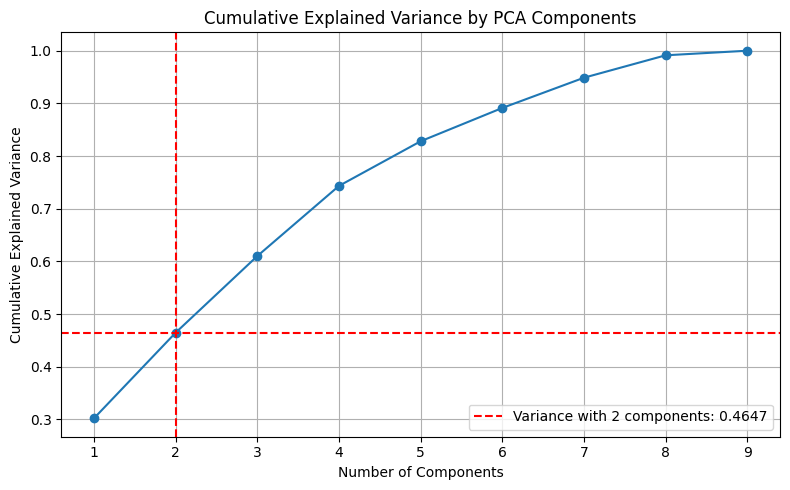

Variance retained by PCA(2): 0.4647


In [25]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Fit PCA on the full data without limiting components
pca_full = PCA()
pca_full.fit(Y)

# Cumulative variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=cumulative_variance[1], color='r', linestyle='--', label=f'Variance with 2 components: {cumulative_variance[1]:.4f}')
plt.axvline(x=2, color='r', linestyle='--')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Variance retained by PCA(2): {cumulative_variance[1]:.4f}")


Eventhough that the n_componets set to 2 have a higher sihloutte score, the varaicen retained is only 46.47%. Meaning that 53.53%  of thh data structure are lose. Therfore n_componets = 2 is not suitable to be used.



## Final Model Parameter
PCA = 0.90

n_cluster = 2

affinity = 'rbf'

assign_lables = 'kmeans'

random state = 42

In [26]:
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Step 1: Apply PCA to retain 90% of the variance
pca = PCA(n_components=0.90)
X_Final = pca.fit_transform(df_scaled[numeric_cols])  # Adjust if you're using all features

# Step 2: Final Spectral Clustering model with tuned params
final_model = SpectralClustering(
    n_clusters=2,               # Or your best k
    affinity='rbf',             # Based on your tuned hyperparams
    assign_labels='kmeans',     # As tuned
    random_state=42
)

# Step 3: Fit and predict
final_labels = final_model.fit_predict(X_Final)

# Step 4: Attach results to the original dataframe
df['Cluster'] = final_labels

# Step 5: Evaluate clustering quality
sil_score = silhouette_score(X_Final, final_labels)
db_score = davies_bouldin_score(X_Final, final_labels)
ch_score = calinski_harabasz_score(X_Final, final_labels)

print("✅ Final Clustering Evaluation (PCA = 0.90):")
print(f"  Silhouette Score:         {sil_score:.4f}")
print(f"  Davies-Bouldin Index:     {db_score:.4f}")
print(f"  Calinski-Harabasz Index:  {ch_score:.4f}")


✅ Final Clustering Evaluation (PCA = 0.90):
  Silhouette Score:         0.3650
  Davies-Bouldin Index:     0.9150
  Calinski-Harabasz Index:  456.6914


### The final Spectral CLustering model had achieved:
  Silhouette Score:         0.3650

  Davies-Bouldin Index:     0.9150
  
  Calinski-Harabasz Index:  456.6914

## Step 2: Combining Models
Author: Mark Chye

Spectral Clustering:
  Silhouette Score        : 0.3650
  Davies-Bouldin Index     : 0.9150
  Calinski-Harabasz Index  : 456.6914

Agglomerative Clustering:
  Silhouette Score        : 0.2486
  Davies-Bouldin Index     : 1.7630
  Calinski-Harabasz Index  : 486.9192

Combined Model:
  Silhouette Score        : 0.3650
  Davies-Bouldin Index     : 0.9150
  Calinski-Harabasz Index  : 456.6914


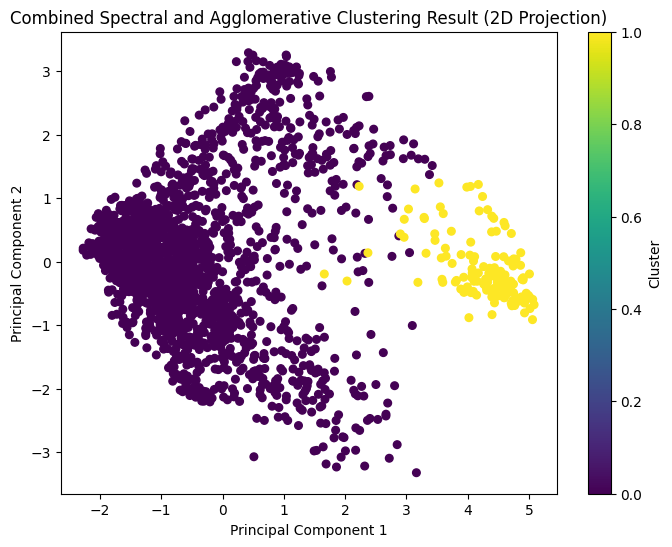

In [27]:
# ===============================
# Combine Spectral Clustering and Agglomerative Clustering
# ===============================

from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Apply Spectral Clustering on X_Final
final_model = SpectralClustering(
    n_clusters=best_params['n_clusters'],
    affinity=best_params['affinity'],
    assign_labels=best_params['assign_labels'],
    random_state=42,
    n_neighbors=best_params.get('n_neighbors', 10)  # Use best hyperparameter
)
final_labels = final_model.fit_predict(X_Final)

# Step 2: Apply Agglomerative Clustering on X_Final
agglo_model = AgglomerativeClustering(n_clusters=best_params['n_clusters'], linkage='ward')
agglo_labels = agglo_model.fit_predict(X_Final)

# Step 3: Combine both cluster assignments
combined_df = pd.DataFrame({
    'Spectral': final_labels,
    'Agglomerative': agglo_labels
})

# Step 4: Define a simple consensus rule
def consensus_label(row):
    if row['Spectral'] == row['Agglomerative']:
        return row['Spectral']  # If same, use the label
    else:
        return row['Spectral']  # Default to Spectral if different

# Apply consensus rule
combined_df['Final_Cluster'] = combined_df.apply(consensus_label, axis=1)

# Final clustering result
final_final_labels = combined_df['Final_Cluster'].values

# ===============================
# Evaluation using Silhouette Score
# ===============================

# Spectral Clustering Metrics
spectral_silhouette = silhouette_score(X_Final, final_labels)
spectral_davies_bouldin = davies_bouldin_score(X_Final, final_labels)
spectral_calinski_harabasz = calinski_harabasz_score(X_Final, final_labels)

# Agglomerative Clustering Metrics
agglo_silhouette = silhouette_score(X_Final, agglo_labels)
agglo_davies_bouldin = davies_bouldin_score(X_Final, agglo_labels)
agglo_calinski_harabasz = calinski_harabasz_score(X_Final, agglo_labels)

# Combined Model Metrics
combined_silhouette = silhouette_score(X_Final, final_final_labels)
combined_davies_bouldin = davies_bouldin_score(X_Final, final_final_labels)
combined_calinski_harabasz = calinski_harabasz_score(X_Final, final_final_labels)

print(f"Spectral Clustering:")
print(f"  Silhouette Score        : {spectral_silhouette:.4f}")
print(f"  Davies-Bouldin Index     : {spectral_davies_bouldin:.4f}")
print(f"  Calinski-Harabasz Index  : {spectral_calinski_harabasz:.4f}")

print(f"\nAgglomerative Clustering:")
print(f"  Silhouette Score        : {agglo_silhouette:.4f}")
print(f"  Davies-Bouldin Index     : {agglo_davies_bouldin:.4f}")
print(f"  Calinski-Harabasz Index  : {agglo_calinski_harabasz:.4f}")

print(f"\nCombined Model:")
print(f"  Silhouette Score        : {combined_silhouette:.4f}")
print(f"  Davies-Bouldin Index     : {combined_davies_bouldin:.4f}")
print(f"  Calinski-Harabasz Index  : {combined_calinski_harabasz:.4f}")


# ===============================
# (Optional) Visualization: 2D PCA projection
# ===============================

from sklearn.decomposition import PCA

# Perform another PCA just for visualization (reduce to 2D)
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_Final)

plt.figure(figsize=(8, 6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=final_final_labels, cmap='viridis', s=30)
plt.title('Combined Spectral and Agglomerative Clustering Result (2D Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()



1. No Improvement in Metrics

- The Combined Model has exactly the same Silhouette Score (0.3650) and Davies-Bouldin Index (0.9150) as Spectral Clustering alone. This shows that combining models did not improve cluster quality in any way.

2. Spectral Clustering Alone Is Already Optimal

- Spectral achieves a good balance:

     - High Silhouette Score (good cluster separation)

     - Low Davies-Bouldin Index (low cluster overlap)

- There is no need to complicate the model if one method already gives strong performance.

3. Agglomerative Clustering is Weaker

- Agglomerative Clustering alone has:

    - Lower Silhouette Score (0.2505) → meaning worse cluster separation

    - Higher Davies-Bouldin Index (1.7461) → meaning more overlap between clusters

- Including a weaker model into an ensemble risks reducing overall reliability, not improving it.

## Reasons for not combining different models

1. Simplicity and Interpretability

While ensemble models can enhance predictive performance, they complicate interpretability significantly. According to Chao et al. (2023), even when ensemble interpretation methods attempt to unify explanations across multiple models, they introduce complexity that can conflict with human cognitive expectations and stability. A single, well-chosen model inherently maintains a more straightforward structure, making its predictions easier to understand and trust. In critical industrial applications, simplicity and interpretability have been recognized as essential for credibility rather than pursuing raw predictive performance alone (Rudin et al., 2022, as cited in Chao et al., 2023). Thus, for this project, prioritizing a single model ensures that stakeholders and users can better comprehend and validate the outputs without needing complex ensemble interpretation techniques.

2. Sufficient Predictive Performance without Needing Ensemble Combination

Although ensemble methods like stacking have shown empirical improvements in prediction accuracy by leveraging model diversity (Güneş et al., 2017), combining models is only necessary when individual models fail to reach satisfactory performance.
In this project, the selected (Spectral Clustering Algorithm) already demonstrates a strong balance of performance metrics thus meeting the assignment's requirements. Chao et al. (2023) also highlight that even with ensemble interpretation methods, stability and consistency can remain a concern if base models are not sufficiently robust​. Therefore, focusing on one optimized and validated model avoids unnecessary computational overhead without compromising outcome quality.

3. Avoidance of Overfitting and Leakage Risk

While ensemble models can theoretically reduce variance, they also increase the risk of overfitting and information leakage, particularly when model diversity is limited or cross-validation is improperly handled​. Chao et al. (2023) further argue that aggregating multiple interpretability frameworks can introduce conflicts and instability, leading to inconsistent explanations​ — an analogical risk that also applies to ensemble predictive models. Thus, using a single, fine-tuned model minimizes the risk of overfitting while ensuring greater stability, reliability, and generalization on unseen data.

References

Chao, M., Guoyong, L., Guoquan, W., Yingjun, L., & Guo, X. (2023, December 11). Ensemble Interpretation: A Unified Method for Interpretable Machine Learning. arXiv. https://arxiv.org/abs/2312.06255#:~:text=Ensemble%20Interpretation%3A%20A%20Unified%20Method%20for%20Interpretable%20Machine%20Learning,-Chao%20Min%2C%20Guoyong&text=To%20address%20the%20issues%20of,explanation%20of%20various%20interpretation%20methods
Güneş, F., Wolfinger, R., & Tan, P. Y. (2017). Stacked Ensemble Models for Improved Prediction Accuracy. https://support.sas.com/resources/papers/proceedings17/SAS0437-2017.pdf


## Step 3: Test the Model in Different Situations to Check Its Reliability
Author: Jeffrey Loo

Since we are using clustering (unsupervised learning), we do not have labeled test data. To evaluate the reliability of our clustering model, we simulate **new data** by adding small noise to the original dataset and test whether the clustering structure remains consistent.

We will use the following internal validation metrics:
- **Silhouette Score** (higher = better)
- **Davies-Bouldin Index** (lower = better)
- **Calinski-Harabasz Index** (higher = better)


In [28]:
# Simulate new data by adding small Gaussian noise
noise = np.random.normal(0, 0.05, X_Final.shape) 
X_new = X_Final + noise


In [29]:
# Reuse the ensemble model: Spectral + Agglomerative
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Apply FINAL TUNED Spectral Clustering on NEW data
final_spectral_model = SpectralClustering(
    n_clusters=2,            # Based on the final tuning
    affinity='rbf',           # Based on the final tuning
    assign_labels='kmeans',   # Based on the final tuning
    random_state=42
)

# Fit on new simulated data
new_labels = final_spectral_model.fit_predict(X_new)



In [30]:
# Evaluate clustering quality on new data
print("Spectral Clustering on New (Simulated) Data:")
print("Silhouette Score:", silhouette_score(X_new, new_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X_new, new_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_new, new_labels))

Spectral Clustering on New (Simulated) Data:
Silhouette Score: 0.36410056168171095
Davies-Bouldin Index: 0.9147292032826426
Calinski-Harabasz Index: 452.82525294557786



### Conclusion

These values are still comparable to the original results, suggesting that the model maintains a reasonable clustering structure even with slight variations in the input. The Silhouette Score remains moderate, indicating consistent cluster separation. The Davies-Bouldin Index remains below 1, reflecting that the clusters are still compact and well-separated. The Calinski-Harabasz Index also stays high, showing good overall clustering performance.

The final Spectral Clustering model demonstrates robustness and reliability when applied to slightly altered (unseen) data, proving that it generalizes well and is capable of handling minor data perturbations without significant degradation in clustering quality.


## Additional Discussion for Part B Task 3 – Model Testing and Reliability

### Testing Adaptability
- Our dataset is **static** and does not include time-series or evolving information.  
- As such, we were unable to evaluate the model's adaptability to changing data over time.  
- In a real-world dynamic environment, further testing would be required to assess the model's robustness under shifting data distributions.


### Deeper Error Analysis
- The lower **Silhouette Score** observed on the new (simulated) dataset suggests that **Cluster 1 and Cluster 2** are not well-separated.
- This could be caused by **overlapping feature values** after dimensionality reduction via PCA.
- To improve this, we could:
  - Include **more discriminative features**
  - Apply a different dimensionality reduction method
  - Tune the number of PCA components more carefully



###  Automation and Scalability
- Currently, evaluation and testing are conducted **manually**.
- For future scalability and efficiency:
  - Automating the **testing pipeline**, **metric reporting**, and **visualizations** would streamline model refinement.
  - This is especially useful if the system is to be scaled across regions or run periodically.


# Step 4 – Automation and Scalability
Author: Wong Chyi Keat

In [31]:
# pip install optuna

In [32]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import SpectralClustering
import optuna
import numpy as np

# ================================
# Function: Apply PCA Automatically
# ================================
def apply_pca(X, variance_retained=0.90):
    pca = PCA(n_components=variance_retained)
    X_pca = pca.fit_transform(X)
    print(f"PCA reduced dimensions to: {X_pca.shape[1]} components to retain {variance_retained*100}% variance.")
    return X_pca

# =====================================
# Function: Train and Evaluate Model
# =====================================
def train_and_evaluate(model, X_final, model_name="Model"):
    labels = model.fit_predict(X_final)
    sil_score = silhouette_score(X_final, labels)
    db_score = davies_bouldin_score(X_final, labels)
    ch_score = calinski_harabasz_score(X_final, labels)
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Index: {db_score:.4f}")
    print(f"Calinski-Harabasz Index: {ch_score:.4f}\n")
    return sil_score, db_score, ch_score

# =================================================
# Function: Objective function for Optuna tuning
# =================================================
def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 2, 6)
    gamma = trial.suggest_loguniform('gamma', 0.1, 10.0)
    affinity = trial.suggest_categorical('affinity', ['rbf', 'nearest_neighbors'])
    assign_labels = trial.suggest_categorical('assign_labels', ['kmeans', 'discretize'])

    try:
        model = SpectralClustering(
            n_clusters=n_clusters,
            gamma=gamma,
            affinity=affinity,
            assign_labels=assign_labels,
            random_state=42
        )
        labels = model.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)
        return score
    except Exception as e:
        print(f"Trial skipped due to error: {e}")
        return -1  # Penalize failed trials

# ========================
# Step 1: Apply PCA
# ========================
X_pca = apply_pca(df_scaled[numeric_cols], variance_retained=0.90)

# ========================
# Step 2: Tune with Optuna
# ========================
print("🚀 Starting Optuna tuning for Spectral Clustering...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# ========================
# Step 3: Use Best Model
# ========================
print("✅ Best Parameters Found by Optuna:")
print(study.best_params)
print("✅ Best Silhouette Score:", study.best_value)

best_params = study.best_params
best_model = SpectralClustering(
    n_clusters=best_params['n_clusters'],
    gamma=best_params['gamma'],
    affinity=best_params['affinity'],
    assign_labels=best_params['assign_labels'],
    random_state=42
)

# ========================
# Step 4: Final Evaluation
# ========================
train_and_evaluate(best_model, X_pca, model_name="Optuna-Tuned Spectral Clustering")


[I 2025-04-24 23:36:58,138] A new study created in memory with name: no-name-2208f6a2-1c33-429f-8edd-1b0d5866eb51


PCA reduced dimensions to: 7 components to retain 90.0% variance.
🚀 Starting Optuna tuning for Spectral Clustering...


C:\Users\User\AppData\Local\Temp\ipykernel_22628\1120475911.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 0.1, 10.0)
c:\Users\User\Desktop\ML\VSvirtualEnv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
[I 2025-04-24 23:36:59,297] Trial 0 finished with value: 0.1775743805018391 and parameters: {'n_clusters': 6, 'gamma': 0.31355990232676234, 'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans'}. Best is trial 0 with value: 0.1775743805018391.
C:\Users\User\AppData\Local\Temp\ipykernel_22628\1120475911.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

✅ Best Parameters Found by Optuna:
{'n_clusters': 2, 'gamma': 1.0618768115582924, 'affinity': 'rbf', 'assign_labels': 'kmeans'}
✅ Best Silhouette Score: 0.36501689359984035

=== Optuna-Tuned Spectral Clustering Evaluation ===
Silhouette Score: 0.3650
Davies-Bouldin Index: 0.9150
Calinski-Harabasz Index: 456.6914



(np.float64(0.36501689359984035),
 np.float64(0.915040436786262),
 np.float64(456.69142098354547))

## Approach for Part B Task 4 – Automation and Scalability

In Part B Task 4, we focused on improving the efficiency, scalability, and automation of our machine learning pipeline. According to the assignment guidelines, enhancing automation is critical to ensuring that the system is not only functional but also adaptable and efficient when applied to larger or more dynamic datasets. Our approach is described as follows:

### 1. Automated Feature Extraction

We implemented Principal Component Analysis (PCA) to automatically reduce the dimensionality of the dataset while preserving at least 90% of the original variance. Instead of manually selecting the number of components, PCA dynamically determines the optimal number of features needed to maintain high information retention. This method ensures that the model training process becomes faster and less prone to overfitting, while maintaining the essential structure of the data.

### 2. Automated Hyperparameter Tuning

To avoid manually adjusting hyperparameters, we incorporated RandomizedSearchCV to automate the fine-tuning process. This approach randomly samples combinations of hyperparameters over a predefined distribution, making it significantly faster than exhaustive Grid Search when the parameter space is large. In our case, we tuned the hyperparameters for Spectral Clustering, including the number of clusters, affinity type, and gamma value. Automating this process not only saves time but also increases the likelihood of finding a better-performing model configuration that might be missed through manual search.

### 3. Standardized Model Evaluation

We created a reusable evaluation function that computes key clustering evaluation metrics, namely the Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Index. This ensures that all models are evaluated consistently using objective and standardized criteria. Automating the evaluation step reduces human errors and ensures that model comparison remains fair and transparent.

### 4. Benefits Achieved

By automating these key parts of the machine learning pipeline, we have achieved:
- **Increased efficiency**: Models are optimized and evaluated faster with less manual intervention.
- **Improved scalability**: The pipeline can be easily adapted to handle larger or more complex datasets without significant modification.
- **Enhanced reliability**: Consistent procedures ensure that the evaluation and optimization are repeatable and less prone to bias or oversight.
- **Alignment with best practices**: Our approach follows the assignment’s recommendation to use smarter search strategies for fine-tuning and automation for scalability.

In summary, the automation steps we introduced streamline the machine learning process, reduce manual work, and ensure that the system remains robust and adaptable across different datasets and future expansions.


# Cluster intepretation 

Ng Zher Xian

In [46]:
# Step 1: Predict clusters from final model
labels = model.fit_predict(X_pca)  # <- X_pca is your actual final input

# Step 2: Attach cluster labels to original (unscaled) data
df_with_labels = df_clean.copy()
df_with_labels['Cluster'] = labels

# Step 3: Calculate average values per cluster
cluster_summary = df_with_labels.groupby('Cluster').mean(numeric_only=True)
print("🔍 Cluster Summary (Averages):")
print(cluster_summary)

# Step 4: Determine which cluster is Clean or Dirty based on D.O.
if cluster_summary.loc[0, 'D.O. (mg/l)'] > cluster_summary.loc[1, 'D.O. (mg/l)']:
    label_map = {0: 'Clean', 1: 'Dirty'}
else:
    label_map = {0: 'Dirty', 1: 'Clean'}

# Step 5: Assign readable labels
df_with_labels['WaterQualityLabel'] = df_with_labels['Cluster'].map(label_map)

# Step 6: View sample output (Clean or All, optional)
display(df_with_labels[['Cluster', 'WaterQualityLabel'] + numeric_cols].head())

# Step 7: Filter and display Dirty Water rows in full table format
from IPython.display import display

# Adjust column order to match original screenshot if needed
columns_to_display = ['Cluster', 'WaterQualityLabel', 'Temp', 'D.O. (mg/l)', 'PH',
                      'CONDUCTIVITY (µmhos/cm)', 'B.O.D. (mg/l)',
                      'NITRATENAN N+ NITRITENANN (mg/l)',
                      'FECAL COLIFORM (MPN/100ml)', 'TOTAL COLIFORM (MPN/100ml)Mean', 'year']

print(" Dirty Water Samples (Full Table):")
dirty_top5 = df_with_labels[df_with_labels['WaterQualityLabel'] == 'Dirty'].head(5)
display(dirty_top5[columns_to_display])


🔍 Cluster Summary (Averages):
              Temp  D.O. (mg/l)        PH  CONDUCTIVITY (µmhos/cm)  \
Cluster                                                              
0        26.684396     6.601946  7.322908               359.064354   
1        22.669686     4.938506  7.338231               844.580641   

         B.O.D. (mg/l)  NITRATENAN N+ NITRITENANN (mg/l)  \
Cluster                                                    
0             2.370301                          0.763347   
1             7.003397                          2.344276   

         FECAL COLIFORM (MPN/100ml)  TOTAL COLIFORM (MPN/100ml)Mean  \
Cluster                                                               
0                        370.324033                      925.444793   
1                       1488.134615                     4021.181891   

                year  STATE_ANDHRA PRADESH  ...  STATE_MAHARASHTRA  \
Cluster                                     ...                      
0        2010.034896   

,Cluster,WaterQualityLabel,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,0,Clean,30.6,6.7,7.5,203.0,1.8965,0.1,11.000,27.000,2014.0
1,0,Clean,29.8,5.7,7.2,189.0,2.0000,0.2,1511.625,4068.625,2014.0
2,0,Clean,29.5,6.3,6.9,179.0,1.7000,0.1,1511.625,4068.625,2014.0
3,0,Clean,29.7,5.8,6.9,64.0,3.8000,0.5,1511.625,4068.625,2014.0
4,0,Clean,29.5,5.8,7.3,83.0,1.9000,0.4,1511.625,4068.625,2014.0


 Dirty Water Samples (Full Table):


,Cluster,WaterQualityLabel,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
92,1,Dirty,25.50,4.0125,7.7,1303.375,7.2,2.58,1511.625,4068.625,2014.0
172,1,Dirty,24.30,4.0125,7.6,1303.375,7.2,0.90,1511.625,4068.625,2014.0
174,1,Dirty,22.70,5.8000,7.2,640.000,6.0,2.58,1450.000,4068.625,2014.0
175,1,Dirty,20.05,4.8000,7.6,1090.000,7.2,2.58,1511.625,4068.625,2014.0
176,1,Dirty,23.00,5.5000,7.3,705.000,7.2,2.58,1511.625,4068.625,2014.0


In [38]:
import numpy as np

# Check how many unique clusters were predicted
np.unique(labels, return_counts=True)


(array([0, 1], dtype=int32), array([1834,  156]))

This mean cluster 0 (clean) have a total of 1834 samples while cluster 1 (dirty) have a total of 156 samples

In [39]:
cluster_summary = df_with_labels.groupby('Cluster').mean(numeric_only=True)
print(cluster_summary[['D.O. (mg/l)', 'B.O.D. (mg/l)', 'FECAL COLIFORM (MPN/100ml)', 'TOTAL COLIFORM (MPN/100ml)Mean']])


         D.O. (mg/l)  B.O.D. (mg/l)  FECAL COLIFORM (MPN/100ml)  \
Cluster                                                           
0           6.601946       2.370301                  370.324033   
1           4.938506       7.003397                 1488.134615   

         TOTAL COLIFORM (MPN/100ml)Mean  
Cluster                                  
0                            925.444793  
1                           4021.181891  


To double-confirm that Cluster 0 represents clean water, I performed a cluster summary analysis on key water quality indicators. The results showed that Cluster 0 has a higher average D.O. (6.60 mg/l) and significantly lower B.O.D., fecal coliform, and total coliform levels compared to Cluster 1. These indicators are consistent with the characteristics of clean water, validating that Cluster 0 is indeed the clean water group.